In [1]:
# Exercise Sheet 5
# Deadline: 
# Philipp Brandauer, Lili Yang, Ma Shijie
import skimage as sk
from skimage import color, data, measure, exposure
import numpy as np
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

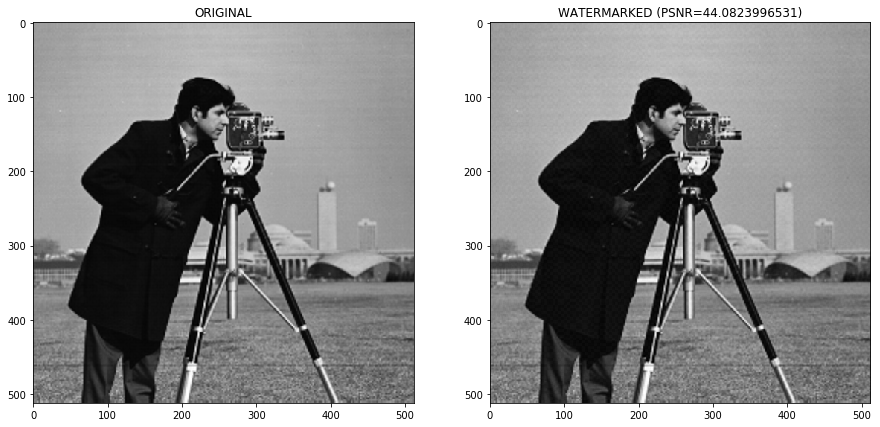

In [2]:
# Exercise 5.1
def generate_watermark(seed, N):
    """ Generates a pseudo random sequenz contaiong -1 and 1.
    Args:
        seed:   Seed for the random generator.
        N:      Length of the generated sequenz.
    Returns:
        Returns a random sequenze of the length N containg -1 and 1."""
    np.random.seed(hash(seed))
    mark = np.random.randint(0, 2, N, dtype=int)
    mark[mark == 0] = -1 #Exchange 0 with -1
    return mark

def embed(img, where, alpha, seed):    
    """ Embed a watermark inside an image using Wavelet transform 
    (Additive spread spectrum watermarking)
    Args:
        img:    Original grayscale image.
        where:  Tuple. Determains in which 'part' of the wavelet transform
                the watermark will be implemented acording to the
                pywt.wavedec2 function output with decomposition level
                acording to the image size (log2!).
        alpha:  Strenght of embedding the watermark.
                (Influences image quality)
        seed:   Seed for the watermark (remember it!).
    Returns:
        Returns the watermarked image and the watermark sequenze."""

    # Get specified part of wavelet transform
    dlevel = int(np.floor(np.log2(img.shape[0])))
    wt = pywt.wavedec2(img, 'haar', level=dlevel)
    if(where[0] == 0):
        subband = wt[0].ravel()
    else:
        subband = wt[where[0]][where[1]].ravel()

    # Embed watermark    
    watermark_sequence = generate_watermark(seed, len(subband))
    subband = subband + alpha*watermark_sequence
    
    # Reconstruct wavelet transform
    sub_shape = (int(np.sqrt(len(subband))), int(np.sqrt(len(subband))))
    if(where[0] == 0):
        wt[0] = subband.reshape(sub_shape)
    else:
        coffs = list(wt[where[0]])
        coffs[where[1]] = subband.reshape(sub_shape)
        wt[where[0]] = tuple(coffs)
    watermarked_image = pywt.waverec2(wt, 'haar')
    return watermarked_image, watermark_sequence
    #return exposure.rescale_intensity(watermarked_image, in_range=(0, 1)), watermark_sequence

# Test
#img_original = data.imread('beach.jpg', as_grey=True)
img_original = sk.img_as_float(color.rgb2gray(data.camera()))
img_wm, wm_seq = embed(img_original, (7, 2), 0.05, '06111992')
# Plot
plt.figure(1, figsize=(15, 15))
plt.subplot(121)
plt.imshow(img_original, cmap='gray')
plt.title('ORIGINAL')
plt.subplot(122)
plt.imshow(img_wm, cmap='gray')
plt.title('WATERMARKED (PSNR=' + str(measure.compare_psnr(img_original, img_wm)) + ')')
plt.show()

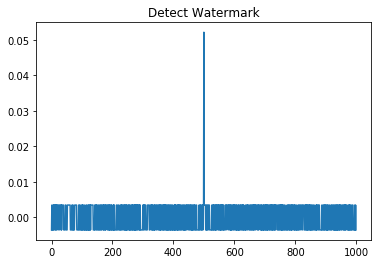

In [3]:
# Exercise 5.2
def detect(img, where, w):
    # Get specified part of wavelet transform
    dlevel = int(np.floor(np.log2(img.shape[0])))
    wt = pywt.wavedec2(img, 'haar', level=dlevel)
    if(where[0] == 0):
        subband = wt[0].ravel()
    else:
        subband = wt[where[0]][where[1]].ravel()
        
    # Detect watermark signal
    return np.sum(subband*w)/len(subband)

# Test
wm_img, wm = embed(img_original, (7,2), 0.05, 1234)
# Create brute force watermark sequences
bruteforce = list(np.zeros(1000))
for i in range(0, 1000):
    bruteforce[i] = detect(wm_img, (7,2), generate_watermark(i, 1))
bruteforce[500] = detect(wm_img, (7,2), wm)
# Plot
plt.plot(bruteforce)
plt.title('Detect Watermark')
plt.show()

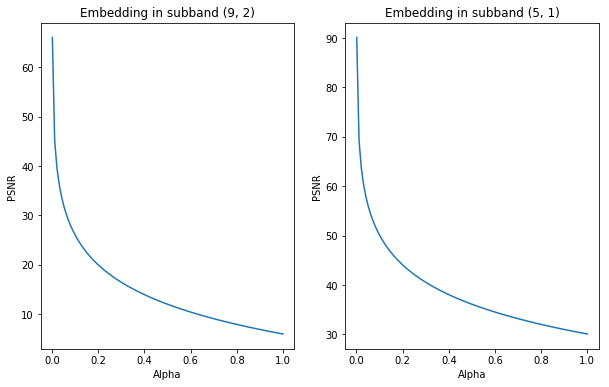

In [6]:
# Bonus
psnr_high = np.zeros(100)
psnr_small = np.zeros(100)
alphas = np.linspace(0.001, 1, 100)
for i, a in zip(range(0, 100), alphas):
    psnr_high[i] = measure.compare_psnr(img_original, embed(img_original, (9, 2), a, '06111992')[0])
    psnr_small[i] = measure.compare_psnr(img_original, embed(img_original, (5, 1), a, '06111992')[0])

# Plot
plt.figure(2, figsize=(10, 6))
plt.subplot(121)
plt.plot(alphas, psnr_high)
plt.xlabel('Alpha')
plt.ylabel('PSNR')
plt.title('Embedding in subband (9, 2)')
plt.subplot(122)
plt.plot(alphas, psnr_small)
plt.xlabel('Alpha')
plt.ylabel('PSNR')
plt.title('Embedding in subband (5, 1)')
plt.show()